# Review

In [1]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

In [5]:
(x_train, y_train), (x_test, y_test)\
= keras.datasets.mnist.load_data()

print(x_train.shape, x_test.shape)

(60000, 28, 28) (10000, 28, 28)


In [6]:
x_train = (x_train/255.).reshape(-1, 28, 28, 1)
x_test = (x_test/255.).reshape(-1, 28, 28, 1)

print(x_train.dtype, y_train.dtype)

float64 uint8


In [7]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                             input_shape = (28,28,1)))
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(10, activation='softmax'))

In [8]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics='accuracy')

In [9]:
if not os.path.exists('./model/'):
    os.mkdir('./model/')

In [10]:
modelpath = './model/{epoch:03d}-{val_loss:.4f}.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=modelpath,
    verbose=1,
    save_best_only=True
)
stoppoint = keras.callbacks.EarlyStopping(patience=5)

In [11]:
hist = model.fit(x_train, y_train, validation_data=(x_test,y_test),
                epochs=30, batch_size=100,
                callbacks=[checkpoint, stoppoint])

Epoch 1/30
600/600 [==============================] - ETA: 0s - loss: 0.1829 - accuracy: 0.9441
Epoch 1: val_loss improved from inf to 0.05374, saving model to ./model\001-0.0537.hdf5
600/600 [==============================] - 75s 124ms/step - loss: 0.1829 - accuracy: 0.9441 - val_loss: 0.0537 - val_accuracy: 0.9813
Epoch 2/30
600/600 [==============================] - ETA: 0s - loss: 0.0595 - accuracy: 0.9820
Epoch 2: val_loss improved from 0.05374 to 0.03500, saving model to ./model\002-0.0350.hdf5
600/600 [==============================] - 73s 122ms/step - loss: 0.0595 - accuracy: 0.9820 - val_loss: 0.0350 - val_accuracy: 0.9878
Epoch 3/30
600/600 [==============================] - ETA: 0s - loss: 0.0404 - accuracy: 0.9877
Epoch 3: val_loss did not improve from 0.03500
600/600 [==============================] - 73s 122ms/step - loss: 0.0404 - accuracy: 0.9877 - val_loss: 0.0354 - val_accuracy: 0.9874
Epoch 4/30
600/600 [==============================] - ETA: 0s - loss: 0.0300 - accu

# GAN

In [17]:
# 생성자모델
generator = keras.Sequential()
generator.add(keras.layers.Dense(7*7*128, input_dim=100,
                                activation=keras.layers.LeakyReLU(0.2)))
# 데이터의 배치를 정규 분포로 만듬 - 배치 정규화 BatchNormalization
# 앞 layer의 활성함수를 통과하기 전에 통과한다.
generator.add(keras.layers.BatchNormalization())
generator.add(keras.layers.Reshape((7, 7, 128)))
generator.add(keras.layers.UpSampling2D())
generator.add(keras.layers.Conv2D(64, kernel_size=5, padding = 'same'))
generator.add(keras.layers.BatchNormalization())
generator.add(keras.layers.Activation(keras.layers.LeakyReLU(0.2)))
generator.add(keras.layers.UpSampling2D())
generator.add(keras.layers.Conv2D(1, kernel_size=5, padding = 'same',
                                 activation='tanh'))

generator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 6272)              633472    
                                                                 
 batch_normalization_2 (Batc  (None, 6272)             25088     
 hNormalization)                                                 
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 64)      

In [50]:
# 판별자 모델
discriminator = keras.Sequential()
discriminator.add(keras.layers.Conv2D(64, kernel_size=5, strides=2,
                                     input_shape=(28,28,1), padding='same'))
discriminator.add(keras.layers.Activation(keras.layers.LeakyReLU(0.2)))
discriminator.add(keras.layers.Conv2D(128, kernel_size=5, strides=2,
                                     padding='same'))
discriminator.add(keras.layers.Activation(keras.layers.LeakyReLU(0.2)))
discriminator.add(keras.layers.Flatten())
discriminator.add(keras.layers.Dense(1, activation = 'sigmoid'))

discriminator.compile(loss='binary_crossentropy',
                     optimizer='adam',)
discriminator.trainable = False
discriminator.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 activation_5 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 activation_6 (Activation)   (None, 7, 7, 128)         0         
                                                                 
 flatten_3 (Flatten)         (None, 6272)              0         
                                                                 
 dense_8 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 212,865
Trainable params: 0
Non-trainabl

In [51]:
# GAN 모델
ginput = keras.layers.Input(shape = (100,))
dis_output = discriminator(generator(ginput))
gan = keras.models.Model(ginput, dis_output)

gan.compile(loss='binary_crossentropy',
           optimizer='adam',
           )

gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_5 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_8 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [56]:
def gan_train(epoch, batch_size, saving_interval):
    (x_train, _), (_,_) = keras.datasets.mnist.load_data()
    x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32)
    x_train = (x_train - 127.5)/127.5

    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    d_losses = []
    g_losses = []

    for i in range(epoch):
        # 실제 이미지 훈련 오차
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)


        # 생성자 오차
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

        d_loss = np.add(d_loss_real, d_loss_fake)/2
        g_loss = gan.train_on_batch(noise, true)

        d_losses.append(d_loss)
        g_losses.append(g_loss)

        print('epoch: {:03d}, d_loss: {:.4f}, g_loss: {:.4f}'.format(
            i, d_loss, g_loss))

        if i % saving_interval == 0:
            noise = np.random.normal(0, 1, (25, 100))
            gen_images = generator.predict(noise)

            gen_imgs = gen_images*0.5 - 0.5

            fig, axe = plt.subplots(5,5)

            count = 0
            for j in range(5):
                for k in range(5):
                    axe[j, k].imshow(gen_imgs[count, :, :, 0], cmap = 'gray')
                    axe[j, k].axis('off')

                    count += 1
            fig.savefig('gan_images/gan_mnist_%d.png' % i)

    return d_losses, g_losses

epoch: 000, d_loss: 0.599610, g_loss: 0.509950
epoch: 001, d_loss: 0.586305, g_loss: 0.498260
epoch: 002, d_loss: 0.651771, g_loss: 0.476839
epoch: 003, d_loss: 0.647204, g_loss: 0.473129
epoch: 004, d_loss: 0.620597, g_loss: 0.467726
epoch: 005, d_loss: 0.642522, g_loss: 0.438604
epoch: 006, d_loss: 0.604198, g_loss: 0.549933
epoch: 007, d_loss: 0.577366, g_loss: 0.585843
epoch: 008, d_loss: 0.598104, g_loss: 0.577805
epoch: 009, d_loss: 0.558135, g_loss: 0.595386
epoch: 010, d_loss: 0.515653, g_loss: 0.592005
epoch: 011, d_loss: 0.516288, g_loss: 0.580986
epoch: 012, d_loss: 0.493431, g_loss: 0.572929
epoch: 013, d_loss: 0.526464, g_loss: 0.559351
epoch: 014, d_loss: 0.454028, g_loss: 0.603261
epoch: 015, d_loss: 0.515122, g_loss: 0.597061
epoch: 016, d_loss: 0.491743, g_loss: 0.720697
epoch: 017, d_loss: 0.446420, g_loss: 0.682654
epoch: 018, d_loss: 0.485829, g_loss: 0.677144
epoch: 019, d_loss: 0.430829, g_loss: 0.719040
epoch: 020, d_loss: 0.434382, g_loss: 0.709492
epoch: 021, d

epoch: 175, d_loss: 0.330228, g_loss: 2.245746
epoch: 176, d_loss: 0.388193, g_loss: 2.399297
epoch: 177, d_loss: 0.529074, g_loss: 2.308356
epoch: 178, d_loss: 0.548030, g_loss: 1.971830
epoch: 179, d_loss: 0.662602, g_loss: 2.001871
epoch: 180, d_loss: 0.649340, g_loss: 1.732180
epoch: 181, d_loss: 0.607061, g_loss: 2.591122
epoch: 182, d_loss: 0.488157, g_loss: 2.399934
epoch: 183, d_loss: 0.751639, g_loss: 2.061556
epoch: 184, d_loss: 0.577080, g_loss: 1.989114
epoch: 185, d_loss: 0.822027, g_loss: 1.571018
epoch: 186, d_loss: 0.780530, g_loss: 1.472745
epoch: 187, d_loss: 0.695451, g_loss: 1.664912
epoch: 188, d_loss: 0.499159, g_loss: 2.002218
epoch: 189, d_loss: 0.556058, g_loss: 2.413127
epoch: 190, d_loss: 0.689138, g_loss: 2.110083
epoch: 191, d_loss: 0.663823, g_loss: 2.302523
epoch: 192, d_loss: 0.650794, g_loss: 1.705948
epoch: 193, d_loss: 0.444561, g_loss: 1.576778
epoch: 194, d_loss: 0.484575, g_loss: 1.729529
epoch: 195, d_loss: 0.300228, g_loss: 2.614306
epoch: 196, d

epoch: 350, d_loss: 0.327579, g_loss: 2.622329
epoch: 351, d_loss: 0.382387, g_loss: 2.062963
epoch: 352, d_loss: 0.215316, g_loss: 2.196593
epoch: 353, d_loss: 0.263435, g_loss: 2.378425
epoch: 354, d_loss: 0.348425, g_loss: 2.319344
epoch: 355, d_loss: 0.224145, g_loss: 2.776448
epoch: 356, d_loss: 0.237820, g_loss: 2.761814
epoch: 357, d_loss: 0.254818, g_loss: 2.689895
epoch: 358, d_loss: 0.268278, g_loss: 2.219603
epoch: 359, d_loss: 0.241278, g_loss: 2.522368
epoch: 360, d_loss: 0.330310, g_loss: 2.132324
epoch: 361, d_loss: 0.202082, g_loss: 2.298019
epoch: 362, d_loss: 0.187904, g_loss: 3.022898
epoch: 363, d_loss: 0.311826, g_loss: 2.346020
epoch: 364, d_loss: 0.213850, g_loss: 2.655103
epoch: 365, d_loss: 0.280671, g_loss: 2.113474
epoch: 366, d_loss: 0.248938, g_loss: 2.403960
epoch: 367, d_loss: 0.275584, g_loss: 2.531156
epoch: 368, d_loss: 0.273104, g_loss: 2.581957
epoch: 369, d_loss: 0.269346, g_loss: 2.609093
epoch: 370, d_loss: 0.305647, g_loss: 2.673771
epoch: 371, d

epoch: 525, d_loss: 0.400600, g_loss: 2.806772
epoch: 526, d_loss: 0.531985, g_loss: 3.362649
epoch: 527, d_loss: 0.828566, g_loss: 2.908060
epoch: 528, d_loss: 0.290621, g_loss: 2.662591
epoch: 529, d_loss: 0.467003, g_loss: 2.281244
epoch: 530, d_loss: 0.396486, g_loss: 1.978232
epoch: 531, d_loss: 0.279897, g_loss: 3.448593
epoch: 532, d_loss: 0.434208, g_loss: 3.294837
epoch: 533, d_loss: 0.427905, g_loss: 3.062684
epoch: 534, d_loss: 1.095928, g_loss: 1.533370
epoch: 535, d_loss: 0.503688, g_loss: 2.643394
epoch: 536, d_loss: 0.993105, g_loss: 2.226675
epoch: 537, d_loss: 0.913958, g_loss: 2.514832
epoch: 538, d_loss: 0.978957, g_loss: 2.401206
epoch: 539, d_loss: 0.676096, g_loss: 2.846383
epoch: 540, d_loss: 0.438984, g_loss: 3.542592
epoch: 541, d_loss: 0.522907, g_loss: 3.259134
epoch: 542, d_loss: 0.742174, g_loss: 2.775649
epoch: 543, d_loss: 0.703135, g_loss: 1.826505
epoch: 544, d_loss: 0.712599, g_loss: 1.744764
epoch: 545, d_loss: 0.480312, g_loss: 2.322980
epoch: 546, d

epoch: 700, d_loss: 0.332436, g_loss: 3.268129
epoch: 701, d_loss: 0.387014, g_loss: 3.085686
epoch: 702, d_loss: 0.302874, g_loss: 2.589229
epoch: 703, d_loss: 0.284180, g_loss: 2.534517
epoch: 704, d_loss: 0.366125, g_loss: 2.631963
epoch: 705, d_loss: 0.419827, g_loss: 2.217167
epoch: 706, d_loss: 0.324169, g_loss: 2.333980
epoch: 707, d_loss: 0.294641, g_loss: 2.681291
epoch: 708, d_loss: 0.404388, g_loss: 2.623077
epoch: 709, d_loss: 0.338807, g_loss: 2.889974
epoch: 710, d_loss: 0.399002, g_loss: 2.580110
epoch: 711, d_loss: 0.424425, g_loss: 2.153367
epoch: 712, d_loss: 0.394940, g_loss: 2.025239
epoch: 713, d_loss: 0.298678, g_loss: 2.337769
epoch: 714, d_loss: 0.207071, g_loss: 2.718912
epoch: 715, d_loss: 0.348196, g_loss: 2.705959
epoch: 716, d_loss: 0.371698, g_loss: 2.560493
epoch: 717, d_loss: 0.352227, g_loss: 2.182018
epoch: 718, d_loss: 0.386201, g_loss: 1.938533
epoch: 719, d_loss: 0.298628, g_loss: 2.097910
epoch: 720, d_loss: 0.376136, g_loss: 2.183453
epoch: 721, d

epoch: 875, d_loss: 0.407872, g_loss: 1.535337
epoch: 876, d_loss: 0.510304, g_loss: 1.603953
epoch: 877, d_loss: 0.273798, g_loss: 2.433030
epoch: 878, d_loss: 0.448910, g_loss: 2.270952
epoch: 879, d_loss: 0.319552, g_loss: 2.527105
epoch: 880, d_loss: 0.420734, g_loss: 1.927267
epoch: 881, d_loss: 0.452310, g_loss: 1.968644
epoch: 882, d_loss: 0.380205, g_loss: 1.994176
epoch: 883, d_loss: 0.409793, g_loss: 2.007972
epoch: 884, d_loss: 0.387265, g_loss: 2.172117
epoch: 885, d_loss: 0.401704, g_loss: 2.076825
epoch: 886, d_loss: 0.411497, g_loss: 2.020516
epoch: 887, d_loss: 0.503624, g_loss: 1.763500
epoch: 888, d_loss: 0.398982, g_loss: 2.148526
epoch: 889, d_loss: 0.390461, g_loss: 2.257546
epoch: 890, d_loss: 0.304379, g_loss: 2.465981
epoch: 891, d_loss: 0.522132, g_loss: 1.920588
epoch: 892, d_loss: 0.456092, g_loss: 1.866467
epoch: 893, d_loss: 0.376079, g_loss: 2.066648
epoch: 894, d_loss: 0.346511, g_loss: 1.994136
epoch: 895, d_loss: 0.511979, g_loss: 1.953571
epoch: 896, d

epoch: 1049, d_loss: 0.595616, g_loss: 1.796619
epoch: 1050, d_loss: 0.427236, g_loss: 1.613805
epoch: 1051, d_loss: 0.393818, g_loss: 1.901638
epoch: 1052, d_loss: 0.354611, g_loss: 1.981492
epoch: 1053, d_loss: 0.447985, g_loss: 1.824237
epoch: 1054, d_loss: 0.459803, g_loss: 1.809272
epoch: 1055, d_loss: 0.556938, g_loss: 1.962338
epoch: 1056, d_loss: 0.375753, g_loss: 2.237680
epoch: 1057, d_loss: 0.443226, g_loss: 2.041979
epoch: 1058, d_loss: 0.692883, g_loss: 1.646006
epoch: 1059, d_loss: 0.565252, g_loss: 1.752903
epoch: 1060, d_loss: 0.396323, g_loss: 1.948474
epoch: 1061, d_loss: 0.549984, g_loss: 2.449363
epoch: 1062, d_loss: 0.451622, g_loss: 2.356081
epoch: 1063, d_loss: 0.586674, g_loss: 1.792229
epoch: 1064, d_loss: 0.439450, g_loss: 1.731560
epoch: 1065, d_loss: 0.326135, g_loss: 2.099485
epoch: 1066, d_loss: 0.200123, g_loss: 2.965880
epoch: 1067, d_loss: 0.270579, g_loss: 2.866903
epoch: 1068, d_loss: 0.341560, g_loss: 2.514791
epoch: 1069, d_loss: 0.343707, g_loss: 2

epoch: 1220, d_loss: 0.563153, g_loss: 1.731126
epoch: 1221, d_loss: 0.388622, g_loss: 1.571331
epoch: 1222, d_loss: 0.293951, g_loss: 1.873522
epoch: 1223, d_loss: 0.290602, g_loss: 2.215686
epoch: 1224, d_loss: 0.251059, g_loss: 2.221224
epoch: 1225, d_loss: 0.275618, g_loss: 2.140022
epoch: 1226, d_loss: 0.323809, g_loss: 1.830738
epoch: 1227, d_loss: 0.279013, g_loss: 1.781804
epoch: 1228, d_loss: 0.378048, g_loss: 1.945669
epoch: 1229, d_loss: 0.252193, g_loss: 2.378640
epoch: 1230, d_loss: 0.337052, g_loss: 2.437756
epoch: 1231, d_loss: 0.455327, g_loss: 2.351647
epoch: 1232, d_loss: 0.236270, g_loss: 2.278341
epoch: 1233, d_loss: 0.342930, g_loss: 1.827864
epoch: 1234, d_loss: 0.491986, g_loss: 1.419874
epoch: 1235, d_loss: 0.328539, g_loss: 2.223334
epoch: 1236, d_loss: 0.304683, g_loss: 2.695012
epoch: 1237, d_loss: 0.343951, g_loss: 2.628668
epoch: 1238, d_loss: 0.305423, g_loss: 2.344844
epoch: 1239, d_loss: 0.325425, g_loss: 1.582681
epoch: 1240, d_loss: 0.319292, g_loss: 2

epoch: 1391, d_loss: 0.394696, g_loss: 2.381033
epoch: 1392, d_loss: 0.430352, g_loss: 1.752009
epoch: 1393, d_loss: 0.494954, g_loss: 1.587074
epoch: 1394, d_loss: 0.480839, g_loss: 1.614879
epoch: 1395, d_loss: 0.416382, g_loss: 2.274368
epoch: 1396, d_loss: 0.411590, g_loss: 2.307986
epoch: 1397, d_loss: 0.524291, g_loss: 2.519834
epoch: 1398, d_loss: 0.583507, g_loss: 2.116253
epoch: 1399, d_loss: 0.449321, g_loss: 1.570260
epoch: 1400, d_loss: 0.659941, g_loss: 1.521385
epoch: 1401, d_loss: 0.577169, g_loss: 1.948264
epoch: 1402, d_loss: 0.418327, g_loss: 2.456216
epoch: 1403, d_loss: 0.754367, g_loss: 2.314939
epoch: 1404, d_loss: 0.447042, g_loss: 2.271876
epoch: 1405, d_loss: 0.410897, g_loss: 1.716247
epoch: 1406, d_loss: 0.591171, g_loss: 1.467484
epoch: 1407, d_loss: 0.425713, g_loss: 1.879221
epoch: 1408, d_loss: 0.447708, g_loss: 2.429205
epoch: 1409, d_loss: 0.371239, g_loss: 2.640339
epoch: 1410, d_loss: 0.492954, g_loss: 2.567735
epoch: 1411, d_loss: 0.550276, g_loss: 1

epoch: 1562, d_loss: 0.590999, g_loss: 1.313921
epoch: 1563, d_loss: 0.507919, g_loss: 1.735193
epoch: 1564, d_loss: 0.496083, g_loss: 1.459306
epoch: 1565, d_loss: 0.358284, g_loss: 1.583780
epoch: 1566, d_loss: 0.559811, g_loss: 1.410782
epoch: 1567, d_loss: 0.498511, g_loss: 1.866195
epoch: 1568, d_loss: 0.487331, g_loss: 1.739703
epoch: 1569, d_loss: 0.499522, g_loss: 1.682761
epoch: 1570, d_loss: 0.516135, g_loss: 1.589869
epoch: 1571, d_loss: 0.413323, g_loss: 1.649097
epoch: 1572, d_loss: 0.534471, g_loss: 1.388495
epoch: 1573, d_loss: 0.455578, g_loss: 1.573619
epoch: 1574, d_loss: 0.386889, g_loss: 1.784260
epoch: 1575, d_loss: 0.426769, g_loss: 1.733102
epoch: 1576, d_loss: 0.611152, g_loss: 1.626043
epoch: 1577, d_loss: 0.609456, g_loss: 1.451037
epoch: 1578, d_loss: 0.460947, g_loss: 1.715746
epoch: 1579, d_loss: 0.523933, g_loss: 1.566270
epoch: 1580, d_loss: 0.532703, g_loss: 1.602046
epoch: 1581, d_loss: 0.537210, g_loss: 1.398137
epoch: 1582, d_loss: 0.617059, g_loss: 1

epoch: 1733, d_loss: 0.443735, g_loss: 2.011857
epoch: 1734, d_loss: 0.463477, g_loss: 1.748456
epoch: 1735, d_loss: 0.469611, g_loss: 1.582557
epoch: 1736, d_loss: 0.534947, g_loss: 1.615303
epoch: 1737, d_loss: 0.638321, g_loss: 1.700570
epoch: 1738, d_loss: 0.479490, g_loss: 1.731122
epoch: 1739, d_loss: 0.443828, g_loss: 1.952209
epoch: 1740, d_loss: 0.441611, g_loss: 1.727656
epoch: 1741, d_loss: 0.506884, g_loss: 1.634660
epoch: 1742, d_loss: 0.295027, g_loss: 2.143344
epoch: 1743, d_loss: 0.291027, g_loss: 2.121416
epoch: 1744, d_loss: 0.342238, g_loss: 1.987429
epoch: 1745, d_loss: 0.522004, g_loss: 1.500806
epoch: 1746, d_loss: 0.396012, g_loss: 1.792536
epoch: 1747, d_loss: 0.399185, g_loss: 1.966376
epoch: 1748, d_loss: 0.390222, g_loss: 2.082335
epoch: 1749, d_loss: 0.503570, g_loss: 1.648025
epoch: 1750, d_loss: 0.590784, g_loss: 1.551805
epoch: 1751, d_loss: 0.483466, g_loss: 1.718656
epoch: 1752, d_loss: 0.394455, g_loss: 1.884215
epoch: 1753, d_loss: 0.600456, g_loss: 1

epoch: 1904, d_loss: 0.514664, g_loss: 1.757714
epoch: 1905, d_loss: 0.500062, g_loss: 2.036997
epoch: 1906, d_loss: 0.309958, g_loss: 2.515897
epoch: 1907, d_loss: 0.619002, g_loss: 2.393095
epoch: 1908, d_loss: 0.469734, g_loss: 1.807956
epoch: 1909, d_loss: 0.409834, g_loss: 1.215516
epoch: 1910, d_loss: 0.375837, g_loss: 1.549000
epoch: 1911, d_loss: 0.453181, g_loss: 1.711172
epoch: 1912, d_loss: 0.446106, g_loss: 2.397852
epoch: 1913, d_loss: 0.310321, g_loss: 2.359620
epoch: 1914, d_loss: 0.541277, g_loss: 1.595227
epoch: 1915, d_loss: 0.378056, g_loss: 1.771787
epoch: 1916, d_loss: 0.448215, g_loss: 1.534298
epoch: 1917, d_loss: 0.547588, g_loss: 1.381381
epoch: 1918, d_loss: 0.407827, g_loss: 1.871703
epoch: 1919, d_loss: 0.481424, g_loss: 1.884717
epoch: 1920, d_loss: 0.446952, g_loss: 1.727410
epoch: 1921, d_loss: 0.318656, g_loss: 2.290260
epoch: 1922, d_loss: 0.644886, g_loss: 1.788346
epoch: 1923, d_loss: 0.574363, g_loss: 1.751354
epoch: 1924, d_loss: 0.389976, g_loss: 1

epoch: 2075, d_loss: 0.417238, g_loss: 1.999849
epoch: 2076, d_loss: 0.499404, g_loss: 1.555198
epoch: 2077, d_loss: 0.366390, g_loss: 1.982193
epoch: 2078, d_loss: 0.317247, g_loss: 2.795718
epoch: 2079, d_loss: 0.446054, g_loss: 2.089706
epoch: 2080, d_loss: 0.474110, g_loss: 1.582594
epoch: 2081, d_loss: 0.438116, g_loss: 1.886783
epoch: 2082, d_loss: 0.360254, g_loss: 2.163709
epoch: 2083, d_loss: 0.411946, g_loss: 1.822887
epoch: 2084, d_loss: 0.337370, g_loss: 2.488223
epoch: 2085, d_loss: 0.424485, g_loss: 2.335425
epoch: 2086, d_loss: 0.446042, g_loss: 1.949069
epoch: 2087, d_loss: 0.462633, g_loss: 1.951450
epoch: 2088, d_loss: 0.500171, g_loss: 1.664873
epoch: 2089, d_loss: 0.388155, g_loss: 1.726018
epoch: 2090, d_loss: 0.358132, g_loss: 2.221854
epoch: 2091, d_loss: 0.512981, g_loss: 1.966304
epoch: 2092, d_loss: 0.440195, g_loss: 2.094238
epoch: 2093, d_loss: 0.491324, g_loss: 1.736291
epoch: 2094, d_loss: 0.525632, g_loss: 1.290905
epoch: 2095, d_loss: 0.495148, g_loss: 1

epoch: 2246, d_loss: 0.445637, g_loss: 1.646344
epoch: 2247, d_loss: 0.377187, g_loss: 2.056708
epoch: 2248, d_loss: 0.344695, g_loss: 1.911849
epoch: 2249, d_loss: 0.262201, g_loss: 2.203410
epoch: 2250, d_loss: 0.345672, g_loss: 2.317801
epoch: 2251, d_loss: 0.414333, g_loss: 2.058706
epoch: 2252, d_loss: 0.208867, g_loss: 2.068447
epoch: 2253, d_loss: 0.446500, g_loss: 2.078182
epoch: 2254, d_loss: 0.376864, g_loss: 1.678054
epoch: 2255, d_loss: 0.444558, g_loss: 1.904206
epoch: 2256, d_loss: 0.286329, g_loss: 2.232759
epoch: 2257, d_loss: 0.477887, g_loss: 2.111520
epoch: 2258, d_loss: 0.537594, g_loss: 2.034666
epoch: 2259, d_loss: 0.406047, g_loss: 1.813694
epoch: 2260, d_loss: 0.425544, g_loss: 2.006630
epoch: 2261, d_loss: 0.416654, g_loss: 2.019413
epoch: 2262, d_loss: 0.424296, g_loss: 2.325472
epoch: 2263, d_loss: 0.468914, g_loss: 2.212463
epoch: 2264, d_loss: 0.377755, g_loss: 1.950827
epoch: 2265, d_loss: 0.340923, g_loss: 1.979345
epoch: 2266, d_loss: 0.513607, g_loss: 1

epoch: 2417, d_loss: 0.403503, g_loss: 2.460149
epoch: 2418, d_loss: 0.276574, g_loss: 2.771573
epoch: 2419, d_loss: 0.254131, g_loss: 3.025836
epoch: 2420, d_loss: 0.352060, g_loss: 2.611959
epoch: 2421, d_loss: 0.382272, g_loss: 2.153458
epoch: 2422, d_loss: 0.313893, g_loss: 1.967817
epoch: 2423, d_loss: 0.418302, g_loss: 1.922515
epoch: 2424, d_loss: 0.275051, g_loss: 2.517871
epoch: 2425, d_loss: 0.282188, g_loss: 2.687150
epoch: 2426, d_loss: 0.295389, g_loss: 2.316959
epoch: 2427, d_loss: 0.263818, g_loss: 2.204739
epoch: 2428, d_loss: 0.429266, g_loss: 2.519692
epoch: 2429, d_loss: 0.352884, g_loss: 2.568138
epoch: 2430, d_loss: 0.387535, g_loss: 2.339015
epoch: 2431, d_loss: 0.308017, g_loss: 2.063257
epoch: 2432, d_loss: 0.241301, g_loss: 1.980309
epoch: 2433, d_loss: 0.287977, g_loss: 2.090483
epoch: 2434, d_loss: 0.426586, g_loss: 2.413036
epoch: 2435, d_loss: 0.549030, g_loss: 1.989715
epoch: 2436, d_loss: 0.389929, g_loss: 1.724560
epoch: 2437, d_loss: 0.490138, g_loss: 1

epoch: 2588, d_loss: 0.371470, g_loss: 1.967025
epoch: 2589, d_loss: 0.419240, g_loss: 2.135119
epoch: 2590, d_loss: 0.364507, g_loss: 2.470978
epoch: 2591, d_loss: 0.400955, g_loss: 2.028416
epoch: 2592, d_loss: 0.412512, g_loss: 2.251165
epoch: 2593, d_loss: 0.335617, g_loss: 2.128964
epoch: 2594, d_loss: 0.540324, g_loss: 2.206899
epoch: 2595, d_loss: 0.430198, g_loss: 2.036797
epoch: 2596, d_loss: 0.383082, g_loss: 1.728861
epoch: 2597, d_loss: 0.507932, g_loss: 1.558073
epoch: 2598, d_loss: 0.335946, g_loss: 2.517833
epoch: 2599, d_loss: 0.519154, g_loss: 2.462621
epoch: 2600, d_loss: 0.393384, g_loss: 2.178303
epoch: 2601, d_loss: 0.506862, g_loss: 1.617190
epoch: 2602, d_loss: 0.430992, g_loss: 2.229714
epoch: 2603, d_loss: 0.325678, g_loss: 2.235632
epoch: 2604, d_loss: 0.513996, g_loss: 1.835007
epoch: 2605, d_loss: 0.430307, g_loss: 2.228639
epoch: 2606, d_loss: 0.378163, g_loss: 2.081146
epoch: 2607, d_loss: 0.393838, g_loss: 2.198304
epoch: 2608, d_loss: 0.346472, g_loss: 2

epoch: 2759, d_loss: 0.524712, g_loss: 1.683356
epoch: 2760, d_loss: 0.367676, g_loss: 1.595090
epoch: 2761, d_loss: 0.452810, g_loss: 2.316550
epoch: 2762, d_loss: 0.392978, g_loss: 2.372950
epoch: 2763, d_loss: 0.442733, g_loss: 1.926699
epoch: 2764, d_loss: 0.338861, g_loss: 1.690383
epoch: 2765, d_loss: 0.462023, g_loss: 1.739876
epoch: 2766, d_loss: 0.435156, g_loss: 1.780842
epoch: 2767, d_loss: 0.325354, g_loss: 2.522624
epoch: 2768, d_loss: 0.427885, g_loss: 2.258469
epoch: 2769, d_loss: 0.451586, g_loss: 1.836844
epoch: 2770, d_loss: 0.335034, g_loss: 1.801060
epoch: 2771, d_loss: 0.357632, g_loss: 2.351913
epoch: 2772, d_loss: 0.406541, g_loss: 1.873917
epoch: 2773, d_loss: 0.391846, g_loss: 2.639619
epoch: 2774, d_loss: 0.424397, g_loss: 2.697990
epoch: 2775, d_loss: 0.302502, g_loss: 2.335327
epoch: 2776, d_loss: 0.428530, g_loss: 2.051201
epoch: 2777, d_loss: 0.424533, g_loss: 1.594478
epoch: 2778, d_loss: 0.425158, g_loss: 1.736433
epoch: 2779, d_loss: 0.392912, g_loss: 2

epoch: 2930, d_loss: 0.261140, g_loss: 1.834862
epoch: 2931, d_loss: 0.526579, g_loss: 1.600063
epoch: 2932, d_loss: 0.279316, g_loss: 2.219813
epoch: 2933, d_loss: 0.294951, g_loss: 2.977702
epoch: 2934, d_loss: 0.419842, g_loss: 2.291363
epoch: 2935, d_loss: 0.498753, g_loss: 2.271163
epoch: 2936, d_loss: 0.512784, g_loss: 1.674736
epoch: 2937, d_loss: 0.394612, g_loss: 1.867576
epoch: 2938, d_loss: 0.377636, g_loss: 2.264051
epoch: 2939, d_loss: 0.417668, g_loss: 2.187377
epoch: 2940, d_loss: 0.623446, g_loss: 1.638007
epoch: 2941, d_loss: 0.491019, g_loss: 1.670436
epoch: 2942, d_loss: 0.448082, g_loss: 2.292897
epoch: 2943, d_loss: 0.576341, g_loss: 2.088886
epoch: 2944, d_loss: 0.436833, g_loss: 1.685830
epoch: 2945, d_loss: 0.352557, g_loss: 1.546680
epoch: 2946, d_loss: 0.488119, g_loss: 1.880472
epoch: 2947, d_loss: 0.646967, g_loss: 1.827249
epoch: 2948, d_loss: 0.457714, g_loss: 2.054701
epoch: 2949, d_loss: 0.473047, g_loss: 2.065212
epoch: 2950, d_loss: 0.463212, g_loss: 1

epoch: 3101, d_loss: 0.274069, g_loss: 2.846155
epoch: 3102, d_loss: 0.435683, g_loss: 2.358410
epoch: 3103, d_loss: 0.664456, g_loss: 1.711808
epoch: 3104, d_loss: 0.487646, g_loss: 2.142925
epoch: 3105, d_loss: 0.373265, g_loss: 2.247834
epoch: 3106, d_loss: 0.381770, g_loss: 2.660127
epoch: 3107, d_loss: 0.599111, g_loss: 2.349970
epoch: 3108, d_loss: 0.533094, g_loss: 1.653397
epoch: 3109, d_loss: 0.526951, g_loss: 1.955714
epoch: 3110, d_loss: 0.367908, g_loss: 2.162960
epoch: 3111, d_loss: 0.383553, g_loss: 2.572577
epoch: 3112, d_loss: 0.425785, g_loss: 2.237605
epoch: 3113, d_loss: 0.414545, g_loss: 2.098397
epoch: 3114, d_loss: 0.526506, g_loss: 1.801653
epoch: 3115, d_loss: 0.555899, g_loss: 1.386880
epoch: 3116, d_loss: 0.505569, g_loss: 1.665073
epoch: 3117, d_loss: 0.420846, g_loss: 2.147359
epoch: 3118, d_loss: 0.534463, g_loss: 2.805394
epoch: 3119, d_loss: 0.513783, g_loss: 2.008905
epoch: 3120, d_loss: 0.321208, g_loss: 1.647835
epoch: 3121, d_loss: 0.443654, g_loss: 1

epoch: 3272, d_loss: 0.334770, g_loss: 1.629939
epoch: 3273, d_loss: 0.429819, g_loss: 2.338392
epoch: 3274, d_loss: 0.371987, g_loss: 2.840808
epoch: 3275, d_loss: 0.415947, g_loss: 2.292122
epoch: 3276, d_loss: 0.321576, g_loss: 1.945212
epoch: 3277, d_loss: 0.335482, g_loss: 2.112640
epoch: 3278, d_loss: 0.239514, g_loss: 2.269854
epoch: 3279, d_loss: 0.277552, g_loss: 2.686641
epoch: 3280, d_loss: 0.281153, g_loss: 2.458335
epoch: 3281, d_loss: 0.310985, g_loss: 2.562403
epoch: 3282, d_loss: 0.246335, g_loss: 2.712408
epoch: 3283, d_loss: 0.328657, g_loss: 2.463983
epoch: 3284, d_loss: 0.376851, g_loss: 2.262933
epoch: 3285, d_loss: 0.213269, g_loss: 3.093009
epoch: 3286, d_loss: 0.278600, g_loss: 3.219464
epoch: 3287, d_loss: 0.484621, g_loss: 2.451838
epoch: 3288, d_loss: 0.380968, g_loss: 2.012691
epoch: 3289, d_loss: 0.343195, g_loss: 1.996514
epoch: 3290, d_loss: 0.464875, g_loss: 1.773694
epoch: 3291, d_loss: 0.476187, g_loss: 2.177953
epoch: 3292, d_loss: 0.519720, g_loss: 2

epoch: 3443, d_loss: 0.598910, g_loss: 1.860340
epoch: 3444, d_loss: 0.367931, g_loss: 2.242238
epoch: 3445, d_loss: 0.467423, g_loss: 2.272628
epoch: 3446, d_loss: 0.564653, g_loss: 2.262825
epoch: 3447, d_loss: 0.355987, g_loss: 2.052410
epoch: 3448, d_loss: 0.357832, g_loss: 2.143131
epoch: 3449, d_loss: 0.610030, g_loss: 2.108662
epoch: 3450, d_loss: 0.502692, g_loss: 1.921347
epoch: 3451, d_loss: 0.711999, g_loss: 1.853281
epoch: 3452, d_loss: 0.467763, g_loss: 1.656235
epoch: 3453, d_loss: 0.362603, g_loss: 1.988399
epoch: 3454, d_loss: 0.479478, g_loss: 1.644355
epoch: 3455, d_loss: 0.609305, g_loss: 2.040173
epoch: 3456, d_loss: 0.516195, g_loss: 1.555218
epoch: 3457, d_loss: 0.401129, g_loss: 2.597372
epoch: 3458, d_loss: 0.486613, g_loss: 2.217229
epoch: 3459, d_loss: 0.400065, g_loss: 2.049798
epoch: 3460, d_loss: 0.261594, g_loss: 2.653484
epoch: 3461, d_loss: 0.264326, g_loss: 2.344306
epoch: 3462, d_loss: 0.334456, g_loss: 2.014705
epoch: 3463, d_loss: 0.279538, g_loss: 2

epoch: 3614, d_loss: 0.244152, g_loss: 2.355481
epoch: 3615, d_loss: 0.408107, g_loss: 2.638674
epoch: 3616, d_loss: 0.441514, g_loss: 2.524763
epoch: 3617, d_loss: 0.411693, g_loss: 2.492232
epoch: 3618, d_loss: 0.584432, g_loss: 2.064689
epoch: 3619, d_loss: 0.451825, g_loss: 1.774096
epoch: 3620, d_loss: 0.388999, g_loss: 2.130453
epoch: 3621, d_loss: 0.251769, g_loss: 2.184788
epoch: 3622, d_loss: 0.409888, g_loss: 2.757659
epoch: 3623, d_loss: 0.420586, g_loss: 2.661736
epoch: 3624, d_loss: 0.416276, g_loss: 2.429061
epoch: 3625, d_loss: 0.524897, g_loss: 2.068202
epoch: 3626, d_loss: 0.340489, g_loss: 2.044154
epoch: 3627, d_loss: 0.393897, g_loss: 2.219837
epoch: 3628, d_loss: 0.308551, g_loss: 2.335528
epoch: 3629, d_loss: 0.286782, g_loss: 2.545521
epoch: 3630, d_loss: 0.432376, g_loss: 2.253895
epoch: 3631, d_loss: 0.374408, g_loss: 2.346213
epoch: 3632, d_loss: 0.303302, g_loss: 2.932265
epoch: 3633, d_loss: 0.463732, g_loss: 2.440802
epoch: 3634, d_loss: 0.360800, g_loss: 2

epoch: 3785, d_loss: 0.429854, g_loss: 1.810119
epoch: 3786, d_loss: 0.431712, g_loss: 1.524471
epoch: 3787, d_loss: 0.428018, g_loss: 2.304013
epoch: 3788, d_loss: 0.210456, g_loss: 3.275644
epoch: 3789, d_loss: 0.439162, g_loss: 2.735311
epoch: 3790, d_loss: 0.334399, g_loss: 2.692286
epoch: 3791, d_loss: 0.307079, g_loss: 2.544730
epoch: 3792, d_loss: 0.225970, g_loss: 2.520205
epoch: 3793, d_loss: 0.328013, g_loss: 2.700410
epoch: 3794, d_loss: 0.262797, g_loss: 2.556997
epoch: 3795, d_loss: 0.406596, g_loss: 2.435489
epoch: 3796, d_loss: 0.443014, g_loss: 2.202829
epoch: 3797, d_loss: 0.619798, g_loss: 2.238396
epoch: 3798, d_loss: 0.385427, g_loss: 2.102840
epoch: 3799, d_loss: 0.367555, g_loss: 2.270517
epoch: 3800, d_loss: 0.528636, g_loss: 2.211349
epoch: 3801, d_loss: 0.331479, g_loss: 2.078351
epoch: 3802, d_loss: 0.437065, g_loss: 2.228016
epoch: 3803, d_loss: 0.583207, g_loss: 2.153579
epoch: 3804, d_loss: 0.458065, g_loss: 1.920280
epoch: 3805, d_loss: 0.413893, g_loss: 2

epoch: 3956, d_loss: 0.433986, g_loss: 1.988498
epoch: 3957, d_loss: 0.425980, g_loss: 2.571743
epoch: 3958, d_loss: 0.299162, g_loss: 2.513180
epoch: 3959, d_loss: 0.291798, g_loss: 2.463145
epoch: 3960, d_loss: 0.283728, g_loss: 2.876903
epoch: 3961, d_loss: 0.244487, g_loss: 2.755520
epoch: 3962, d_loss: 0.374411, g_loss: 2.443042
epoch: 3963, d_loss: 0.416110, g_loss: 2.023949
epoch: 3964, d_loss: 0.471783, g_loss: 2.141125
epoch: 3965, d_loss: 0.395328, g_loss: 1.913186
epoch: 3966, d_loss: 0.430822, g_loss: 2.413470
epoch: 3967, d_loss: 0.483560, g_loss: 2.113606
epoch: 3968, d_loss: 0.375490, g_loss: 2.400365
epoch: 3969, d_loss: 0.437431, g_loss: 2.416783
epoch: 3970, d_loss: 0.421042, g_loss: 1.882390
epoch: 3971, d_loss: 0.288433, g_loss: 2.233374
epoch: 3972, d_loss: 0.327217, g_loss: 1.664641
epoch: 3973, d_loss: 0.379673, g_loss: 1.834145
epoch: 3974, d_loss: 0.398086, g_loss: 2.420326
epoch: 3975, d_loss: 0.309865, g_loss: 2.473979
epoch: 3976, d_loss: 0.532519, g_loss: 1

C:\Users\Mu-jun\AppData\Local\Temp/ipykernel_15888/1971870327.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axe = plt.subplots(5,5)


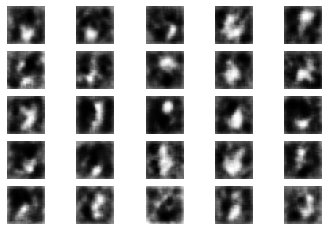

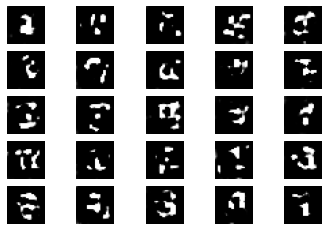

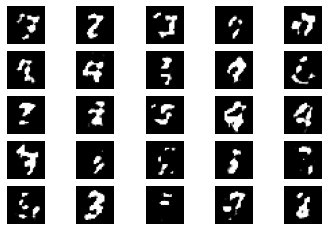

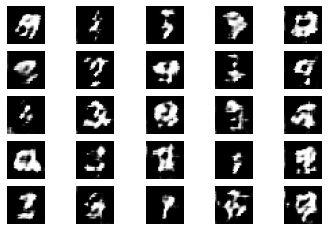

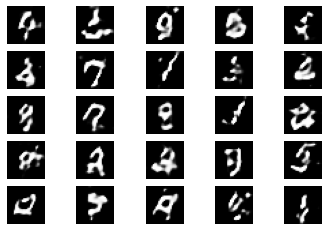

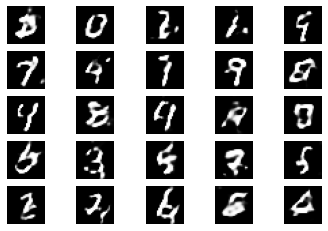

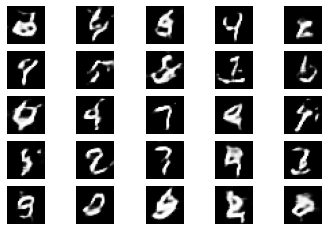

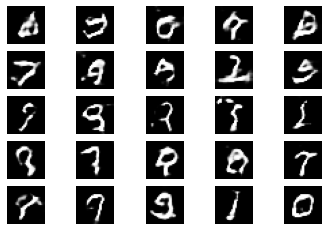

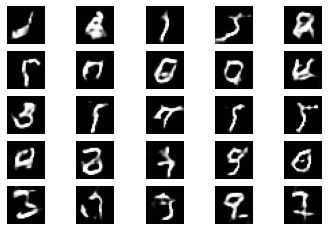

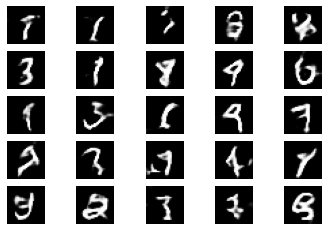

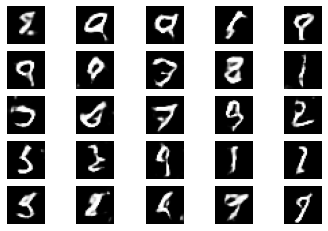

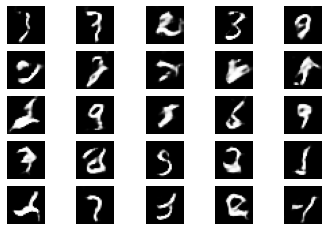

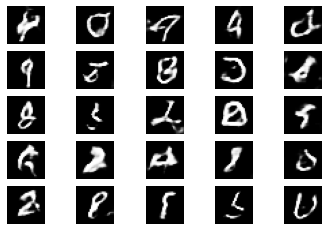

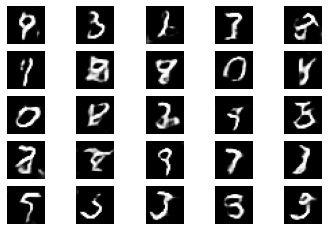

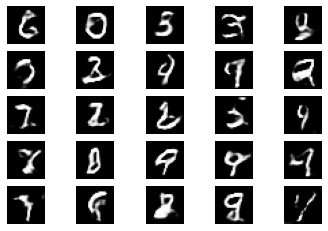

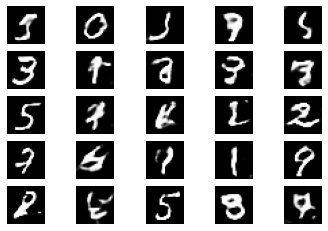

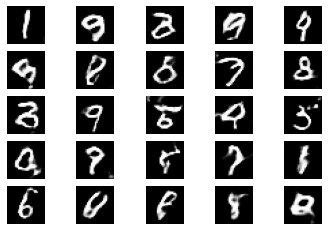

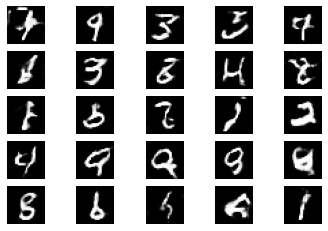

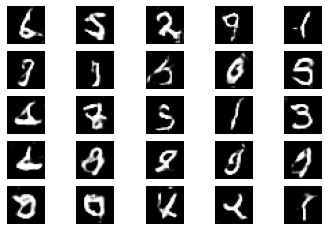

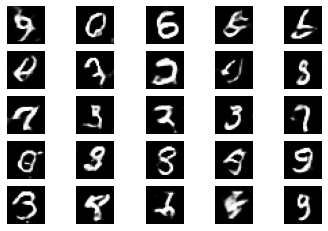

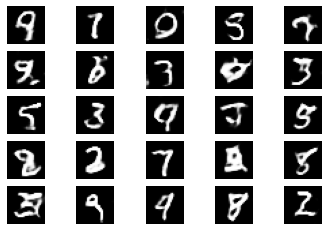

In [57]:
d_losses, g_losses = gan_train(4001, 32, 200)

# 전이학습 Transfer Model

In [59]:
np.random.seed(3)
tf.random.set_seed(3)

In [61]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=5,
    shear_range=0.7,
    zoom_range=[0.9, 2.2],
    vertical_flip=True,
    fill_mode='nearest'
)

In [62]:
train_generator = train_datagen.flow_from_directory(
    directory='./train/',
    target_size=(150,150),
    save_to_dir='./gen_train/',
    batch_size=5,
    class_mode = 'binary'
)

Found 160 images belonging to 2 classes.


In [63]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [64]:
test_generator = test_datagen.flow_from_directory(
    directory='./test',
    save_to_dir='./gen_test/',
    target_size=(150,150),
    batch_size=5,
    class_mode='binary',
)

Found 120 images belonging to 2 classes.


In [65]:
transfer_model = keras.applications.VGG16(weights='imagenet',
                                         include_top = False,
                                         input_shape = (150, 150, 3))
transfer_model.trainable = False
transfer_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [66]:
finetune_model = keras.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(keras.layers.Flatten())
finetune_model.add(keras.layers.Dense(64, activation='relu'))
finetune_model.add(keras.layers.Dense(1, activation='sigmoid'))

finetune_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_9 (Dense)             (None, 64)                524352    
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 15,239,105
Trainable params: 524,417
Non-trainable params: 14,714,688
_________________________________________________________________


In [67]:
finetune_model.compile(loss='binary_crossentropy',
                      optimizer=keras.optimizers.Adam(learning_rate=0.0002),
                       metrics='accuracy')                    

In [68]:
# step_per_epoch = len(X_train) 160//batch_size(5) 보다 작게 설정
# validation_steps = len(X_test) 160//batch_size(5) 보다 작게 설정

hist = finetune_model.fit_generator(train_generator,
                                   steps_per_epoch=10,
                                   epochs=10,
                                   validation_data=test_generator,
                                   validation_steps=4)

Epoch 1/10


C:\Users\Mu-jun\AppData\Local\Temp/ipykernel_15888/1057156494.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = finetune_model.fit_generator(train_generator,


10/10 [==============================] - 6s 546ms/step - loss: 0.8656 - accuracy: 0.5400 - val_loss: 0.8408 - val_accuracy: 0.4000
Epoch 2/10
10/10 [==============================] - 5s 525ms/step - loss: 0.6970 - accuracy: 0.5200 - val_loss: 0.6292 - val_accuracy: 0.8500
Epoch 3/10
10/10 [==============================] - 5s 534ms/step - loss: 0.6282 - accuracy: 0.6200 - val_loss: 0.6230 - val_accuracy: 0.7000
Epoch 4/10
10/10 [==============================] - 5s 511ms/step - loss: 0.6383 - accuracy: 0.6000 - val_loss: 0.5739 - val_accuracy: 0.8000
Epoch 5/10
10/10 [==============================] - 5s 517ms/step - loss: 0.5989 - accuracy: 0.6800 - val_loss: 0.4959 - val_accuracy: 0.8000
Epoch 6/10
10/10 [==============================] - 5s 531ms/step - loss: 0.5523 - accuracy: 0.7000 - val_loss: 0.4468 - val_accuracy: 0.8000
Epoch 7/10
10/10 [==============================] - 5s 511ms/step - loss: 0.5418 - accuracy: 0.7200 - val_loss: 0.5197 - val_accuracy: 0.9000
Epoch 8/10
10/10 

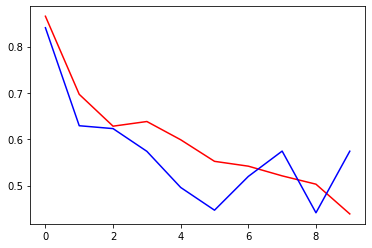

In [69]:
plt.plot(hist.history['loss'], c='r')
plt.plot(hist.history['val_loss'], c='b')

plt.show()